In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split

path = ''
path_to_data = path + 'Original Data/training_set/'
path_to_track_data = path + 'Original Data/track_features/'

seed=123

In [3]:
# Remove sessions with context switches
def remove_sess_with_context_switches(log):
    cs_counts = log[['session_id','context_switch']].groupby('session_id').sum().reset_index()
    sess_nocs = list(cs_counts[cs_counts['context_switch'] == 0]['session_id'])
    
    # Convert cols with 0/1 into bool
    log['context_switch'] = log['context_switch'].astype(bool)
    log['no_pause_before_play'] = log['no_pause_before_play'].astype(bool)
    log['short_pause_before_play'] = log['short_pause_before_play'].astype(bool)
    log['long_pause_before_play'] = log['long_pause_before_play'].astype(bool)
    
    return log[log['session_id'].isin(sess_nocs)].reset_index(drop=True)

# Pick data from 6 random days
## dataset 3
# log1 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180731_000000000000.csv'))
# log2 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180801_000000000000.csv'))
# log3 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180808_000000000000.csv'))
# log4 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180903_000000000000.csv'))
# log5 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180909_000000000000.csv'))
# log6 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180911_000000000000.csv'))
## dataset 3
# log1 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180918_000000000000.csv'))
# log2 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180730_000000000000.csv'))
# log3 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180815_000000000000.csv'))
# log4 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180822_000000000000.csv'))
# log5 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180901_000000000000.csv'))
# log6 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180728_000000000000.csv'))
## dataset 2
# log1 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180715_000000000000.csv'))
# log2 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180722_000000000000.csv'))
# log3 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180804_000000000000.csv'))
# log4 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180828_000000000000.csv'))
# log5 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180912_000000000000.csv'))
# log6 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180818_000000000000.csv'))
## dataset 1 (main)
log1 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180717_000000000000.csv'))
log2 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180724_000000000000.csv'))
log3 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180806_000000000000.csv'))
log4 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180830_000000000000.csv'))
log5 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180915_000000000000.csv'))
log6 = remove_sess_with_context_switches(pd.read_csv(path_to_data + 'log_0_20180820_000000000000.csv'))

In [5]:
NUM_SAMPLES = 40000 # No. of sessions to sample from each file
sample_sess = lambda x: pd.Series(x['session_id'].unique()).sample(NUM_SAMPLES, random_state=seed)

log1_sampled = log1[log1['session_id'].isin(sample_sess(log1))].reset_index(drop=True)
log2_sampled = log2[log2['session_id'].isin(sample_sess(log2))].reset_index(drop=True)
log3_sampled = log3[log3['session_id'].isin(sample_sess(log3))].reset_index(drop=True)
log4_sampled = log4[log4['session_id'].isin(sample_sess(log4))].reset_index(drop=True)
log5_sampled = log5[log5['session_id'].isin(sample_sess(log5))].reset_index(drop=True)
log6_sampled = log6[log6['session_id'].isin(sample_sess(log6))].reset_index(drop=True)

In [6]:
train = pd.concat([log1_sampled,log2_sampled,log3_sampled,log4_sampled,log5_sampled]).reset_index(drop=True)
test = log6_sampled

train.shape, test.shape, train['session_id'].nunique(), test['session_id'].nunique()

((3284067, 21), (651735, 21), 200000, 40000)

In [7]:
# Load track metadata
track0 = pd.read_csv(path_to_track_data + 'tf_000000000000.csv')
track1 = pd.read_csv(path_to_track_data + 'tf_000000000001.csv')
tracks = track0.append(track1)

In [8]:
# Form train, val, test set
train_sess_ids, val_sess_ids = train_test_split(train['session_id'].unique(), test_size=0.2, random_state=seed)
trainz = train[train['session_id'].isin(train_sess_ids)]
valz = train[train['session_id'].isin(val_sess_ids)]

train = trainz.merge(tracks, left_on='track_id_clean', right_on='track_id')
train.sort_values(by=['session_id', 'session_position'], inplace=True)
train = train.reset_index(drop=True)

val = valz.merge(tracks, left_on='track_id_clean', right_on='track_id')
val.sort_values(by=['session_id', 'session_position'], inplace=True)
val = val.reset_index(drop=True)

test = test.merge(tracks, left_on='track_id_clean', right_on='track_id')
test.sort_values(by=['session_id', 'session_position'], inplace=True)
test = test.reset_index(drop=True)

train

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,22_0000f2fc-143f-41ab-a46e-d24f8de9af52,1,15,t_6af8ddc3-88dd-4107-9d86-ff457a94e095,False,False,False,True,False,False,...,4,0.860578,-0.506540,0.066303,0.308754,0.099178,0.231540,0.138632,-0.248594,-0.032736
1,22_0000f2fc-143f-41ab-a46e-d24f8de9af52,2,15,t_6017a19e-c80b-44aa-8082-027d7a239cf7,False,False,True,False,False,True,...,4,0.863891,-0.634187,0.101961,0.317427,0.199928,0.197700,0.099790,-0.152495,0.050981
2,22_0000f2fc-143f-41ab-a46e-d24f8de9af52,3,15,t_fa5ab487-ab49-48ef-adb5-f987679bd4c4,False,True,True,False,False,True,...,4,0.682992,-0.648128,0.079560,0.394614,0.251039,0.112599,0.099564,-0.121302,-0.013774
3,22_0000f2fc-143f-41ab-a46e-d24f8de9af52,4,15,t_c4faeeae-e295-4752-b015-b45257803a45,True,True,True,False,False,True,...,4,0.297876,-0.013097,0.287468,0.378081,-0.294970,-0.013921,0.177360,-0.211256,-0.519585
4,22_0000f2fc-143f-41ab-a46e-d24f8de9af52,5,15,t_14de5c5c-6aa2-41cd-81ad-e4768f7d7691,False,False,False,True,False,True,...,4,0.958714,-0.599022,0.029001,0.390504,0.217310,0.157821,0.132032,-0.202796,-0.014954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2626959,9_ffff906e-a396-4122-8236-dd140a2ba83f,16,20,t_7fecd290-5e09-485e-988a-8f81d33fd5e6,False,False,False,False,False,False,...,4,0.226136,-0.906557,0.304528,0.234190,0.138765,-0.281217,-0.054698,-0.570255,0.117993
2626960,9_ffff906e-a396-4122-8236-dd140a2ba83f,17,20,t_fec4d8aa-7ff4-418b-b3d8-835ca0f7672e,False,False,True,False,False,False,...,4,0.298573,-0.803079,0.298038,0.191851,0.143363,-0.296345,-0.058390,-0.414442,0.097394
2626961,9_ffff906e-a396-4122-8236-dd140a2ba83f,18,20,t_7fecd290-5e09-485e-988a-8f81d33fd5e6,True,True,True,False,False,True,...,4,0.226136,-0.906557,0.304528,0.234190,0.138765,-0.281217,-0.054698,-0.570255,0.117993
2626962,9_ffff906e-a396-4122-8236-dd140a2ba83f,19,20,t_4765bee9-42e7-4308-bb17-b2966a60a31e,True,True,True,False,False,True,...,4,0.464020,-0.826509,0.362637,0.290938,0.054799,-0.328719,0.010390,-0.455184,0.206001


In [9]:
train.shape, val.shape, test.shape

((2626964, 51), (657103, 51), (651735, 51))

In [10]:
train['session_id'].nunique(), val['session_id'].nunique(), test['session_id'].nunique()

(160000, 40000, 40000)

Text(0, 0.5, 'Skip rate')

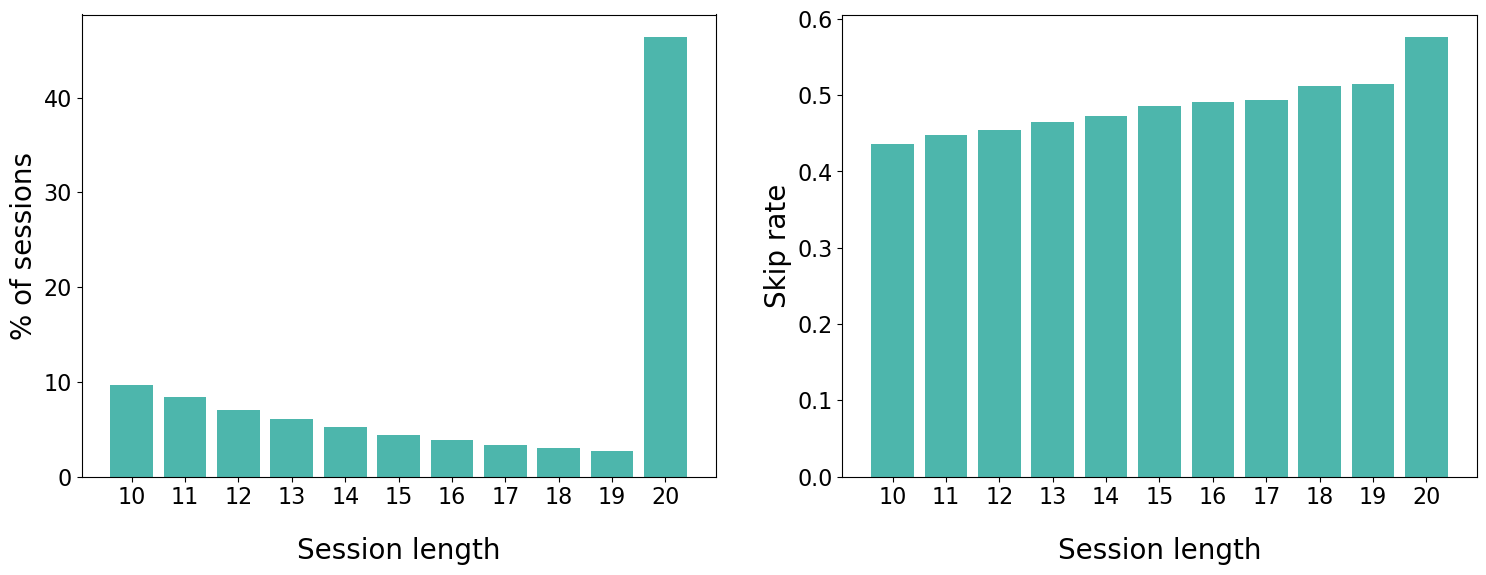

In [29]:
# Plots on session lengths and skip rate
sess_length = train[['session_id','session_length']].groupby('session_id').mean()['session_length'].value_counts().sort_index() / train['session_id'].nunique() * 100
sess_skip = train[['session_id','session_length','skip_2']].groupby('session_id').mean().groupby('session_length').mean()['skip_2']

f, ax = plt.subplots(1,2, figsize=(18,6))
plt.rcParams.update(plt.rcParamsDefault)
plt.subplots_adjust(hspace = 0.4)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

ax[0].bar(sess_length.index, sess_length.values, color='#4db6ac')
ax[0].set_xticks(range(10,21))
ax[0].set_xlabel('Session length', labelpad=20)
ax[0].set_ylabel('% of sessions')

ax[1].bar(sess_skip.index, sess_skip.values, color='#4db6ac')
ax[1].set_xticks(range(10,21))
ax[1].set_xlabel('Session length', labelpad=20)
ax[1].set_ylabel('Skip rate')

In [22]:
N=5

# Remove sessions with all skips/non-skips in firstN and remaining tracks
def filter_sessions(data):
    data_sess = data[['session_id','session_position','skip_2']]
    data_sess['relevance'] = data_sess['skip_2'].astype(int)
    data_sess['relevance'] = data_sess['relevance'] ^ 1
    
    data_firstN = data_sess[data_sess['session_position']<=N].groupby('session_id').sum().reset_index()
    data_rem = data_sess[data_sess['session_position']>N].groupby('session_id').sum().reset_index()
    
    data_filt = data_firstN[['session_id','relevance']]
    data_filt = data_filt.rename(columns={'relevance':'firstN'})
    data_filt['session_length'] = list(data_sess.groupby('session_id').max()['session_position'])
    data_filt = data_filt.merge(data_rem[['session_id','relevance']], on='session_id')
    data_filt = data_filt.rename(columns={'relevance':'remaining'})
    # data_filt['remaining_all'] = data_filt['session_length'] - N
    
    data_filt = data_filt[(data_filt['firstN']!=0)&(data_filt['firstN']!=N)&(data_filt['remaining']!=0)].reset_index(drop=True)
    # &(data_filt['remaining_all']!=data_filt['remaining'])
    return data_filt

filter_sessions(train)

/Users/aaronng/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aaronng/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,session_id,firstN,session_length,remaining
0,16_0000cfd4-516d-4ec7-add6-675b43c37703,4,12,5
1,16_00062366-df8d-44db-aacd-2387f244558b,1,14,3
2,16_0006afec-0751-45e3-91a8-9a8889c6ab57,4,13,4
3,16_000915d0-dd95-407b-9247-f972d3f3968b,2,20,2
4,16_000ba476-e7c0-4e20-b673-99bb96d76feb,3,20,4
...,...,...,...,...
102507,56_fff29d5a-bee7-4b51-996b-606ef8856b82,3,20,2
102508,56_fff6830f-e50a-4566-9301-51c298119917,1,20,11
102509,56_fff7c178-8e26-40f2-8501-8d7c3988d253,1,20,3
102510,56_fff9827e-6c03-43c3-8f36-39041f032b2c,4,11,6


In [23]:
# Specify subset of train,val,test set to extract
train_sess_ids = list(filter_sessions(train)['session_id'].sample(100000, random_state=seed))
val_sess_ids = list(filter_sessions(val)['session_id'].sample(25000, random_state=seed))
test_sess_ids = list(filter_sessions(test)['session_id'].sample(25000, random_state=seed))
len(train_sess_ids),len(val_sess_ids),len(test_sess_ids)

/Users/aaronng/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aaronng/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(100000, 25000, 25000)

In [24]:
train_final = train[train['session_id'].isin(train_sess_ids)].reset_index(drop=True)
val_final = val[val['session_id'].isin(val_sess_ids)].reset_index(drop=True)
test_final = test[test['session_id'].isin(test_sess_ids)].reset_index(drop=True)

In [17]:
# Save data to file
train_final.to_csv(path + 'train4.csv', index=False)
val_final.to_csv(path + 'val4.csv', index=False)
test_final.to_csv(path + 'test4.csv', index=False)

## Track Stats

In [ ]:
# Track Statistics

f, ax = plt.subplots(4, 4, figsize=(30,20))
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

log['session_length'].value_counts(sort=False).plot(ax=ax[0][0], kind='bar')
log['skip_1'].value_counts(sort=False).plot(ax=ax[0][1], kind='bar')
log['skip_2'].value_counts(sort=False).plot(ax=ax[0][2], kind='bar')
log['skip_3'].value_counts(sort=False).plot(ax=ax[0][3], kind='bar')
log['context_switch'].value_counts(sort=False).plot(ax=ax[1][0], kind='bar')
log['no_pause_before_play'].value_counts(sort=False).plot(ax=ax[1][1], kind='bar')
log['short_pause_before_play'].value_counts(sort=False).plot(ax=ax[1][2], kind='bar')
log['long_pause_before_play'].value_counts(sort=False).plot(ax=ax[1][3], kind='bar')
log['hist_user_behavior_n_seekfwd'].value_counts(sort=False).plot(ax=ax[2][0], kind='bar')
log['hist_user_behavior_n_seekback'].value_counts(sort=False).plot(ax=ax[2][1], kind='bar')
log['hist_user_behavior_is_shuffle'].value_counts(sort=False).plot(ax=ax[2][2], kind='bar')
log['premium'].value_counts(sort=False).plot(ax=ax[2][3], kind='bar')
log['context_type'].value_counts(sort=False).plot(ax=ax[3][0], kind='bar')
log['hist_user_behavior_reason_start'].value_counts(sort=False).plot(ax=ax[3][1], kind='bar')
log['hist_user_behavior_reason_end'].value_counts(sort=False).plot(ax=ax[3][2], kind='bar')
log['hour_of_day'].value_counts(sort=False).plot(ax=ax[3][3], kind='bar')

ax[0][0].title.set_text('Session Length')
ax[0][1].title.set_text('Skip 1')
ax[0][2].title.set_text('Skip 2')
ax[0][3].title.set_text('Skip 3')
ax[1][0].title.set_text('Context Switch')
ax[1][1].title.set_text('No Pause')
ax[1][2].title.set_text('Short Pause')
ax[1][3].title.set_text('Long Pause')
ax[2][0].title.set_text('No. Seek Forward')
ax[2][1].title.set_text('No. Seek Backward')
ax[2][2].title.set_text('Shuffle')
ax[2][3].title.set_text('Premium')
ax[3][0].title.set_text('Context Type')
ax[3][1].title.set_text('Behaviour Reason Start')
ax[3][2].title.set_text('Behaviour Reason End')
ax[3][3].title.set_text('Hour of Day');

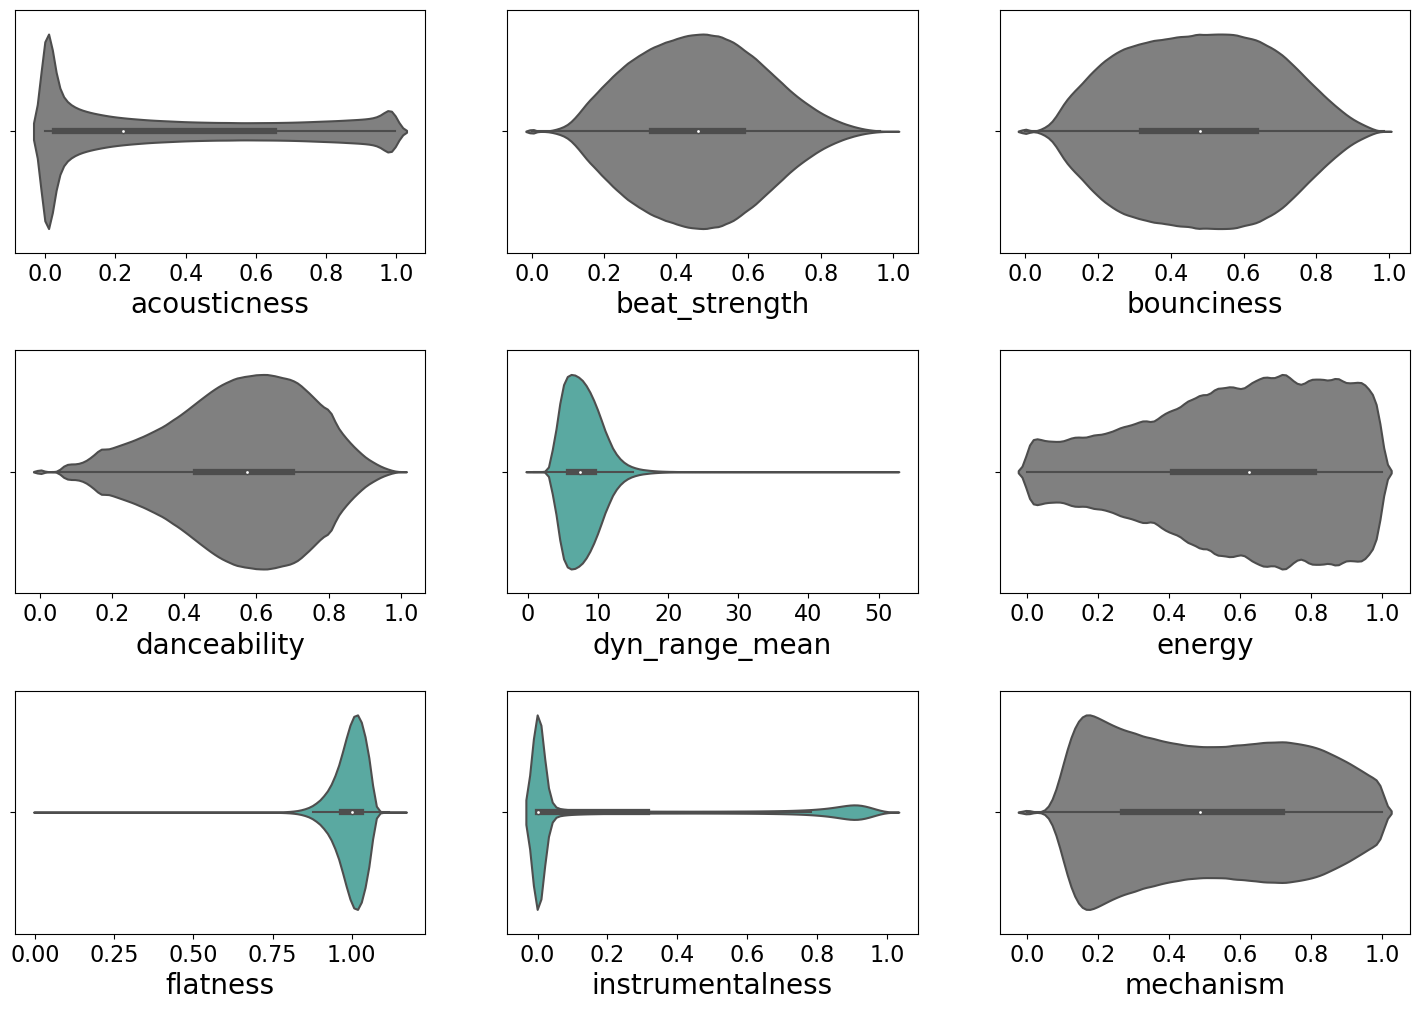

In [5]:
# Track Statistics

f, ax = plt.subplots(3, 3, figsize=(18,12))
# plt.suptitle('(b)')
# sns.violinplot(track['duration'], ax=ax[0][0])
# sns.violinplot(track['release_year'], ax=ax[0][1])
# sns.violinplot(track['us_popularity_estimate'], ax=ax[0][2])
plt.rcParams.update(plt.rcParamsDefault)
plt.subplots_adjust(hspace = 0.4)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

sns.violinplot(tracks['acousticness'], ax=ax[0][0], color='gray')
sns.violinplot(tracks['beat_strength'], ax=ax[0][1], color='gray')
sns.violinplot(tracks['bounciness'], ax=ax[0][2], color='gray')

# sns.violinplot(tracks['flatness'], ax=ax[1][0], color='#4db6ac')
# sns.violinplot(tracks['instrumentalness'], ax=ax[1][1], color='#4db6ac')
# sns.violinplot(tracks['energy'], ax=ax[1][2], color='gray')

sns.violinplot(tracks['danceability'], ax=ax[1][0], color='gray')
sns.violinplot(tracks['dyn_range_mean'], ax=ax[1][1], color='#4db6ac')
sns.violinplot(tracks['energy'], ax=ax[1][2], color='gray')

sns.violinplot(tracks['flatness'], ax=ax[2][0], color='#4db6ac')
sns.violinplot(tracks['instrumentalness'], ax=ax[2][1], color='#4db6ac')
sns.violinplot(tracks['mechanism'], ax=ax[2][2], color='gray')

# sns.violinplot(tracks['liveness'], ax=ax[3][0])
# sns.violinplot(tracks['loudness'], ax=ax[3][1])
# sns.violinplot(tracks['mechanism'], ax=ax[3][2])

# sns.violinplot(pd.Series(np.where(tracks['mode'] =='major', 1, 0), name='mode'), ax=ax[4][0])
# sns.violinplot(tracks['organism'], ax=ax[4][1])
# sns.violinplot(tracks['speechiness'], ax=ax[4][2])

# sns.violinplot(tracks['tempo'], ax=ax[5][0])
# sns.violinplot(tracks['time_signature'], ax=ax[5][1])
# sns.violinplot(tracks['valence'], ax=ax[5][2])

In [6]:
# Convert cols with 0/1 into bool
log['context_switch'] = log['context_switch'].astype(bool)
log['no_pause_before_play'] = log['no_pause_before_play'].astype(bool)
log['short_pause_before_play'] = log['short_pause_before_play'].astype(bool)
log['long_pause_before_play'] = log['long_pause_before_play'].astype(bool)

log.rename(columns={'track_id_clean': 'track_id'}, inplace=True)